In this kernel we will take a look at engineering aggregated features. Specifically, we will engineer 3 aggregated features using `train_active.csv`, `test_active.csv`, `periods_test.csv` and `periods_test.csv`. Those features will be:
- `avg_times_up_user` - how often the average item of the user has been put up for sale.
- `avg_days_up_user` - the average number of days an item from the user has been put up for sale.
- `n_user_items` - the number of items the user has put up for sale.

Let's see if they help :)

# Engineering aggregated features

In [49]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib_venn import venn2, venn2_circles
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

sns.set()
%matplotlib inline

Start with loading the data. To save some memory, we only load `item_id` and `user_id`, as that's all we need for the proposed features.

In [50]:
used_cols = ['item_id', 'user_id']

train = pd.read_csv('../train.csv', usecols=used_cols)
train_active = pd.read_csv('../train_active.csv', usecols=used_cols)
test = pd.read_csv('../test.csv', usecols=used_cols)
test_active = pd.read_csv('../test_active.csv', usecols=used_cols)

train_periods = pd.read_csv('../periods_train.csv', parse_dates=['date_from', 'date_to'])
test_periods = pd.read_csv('../periods_test.csv', parse_dates=['date_from', 'date_to'])

train.head()

,item_id,user_id
0,b912c3c6a6ad,e00f8ff2eaf9
1,2dac0150717d,39aeb48f0017
2,ba83aefab5dc,91e2f88dd6e3
3,02996f1dd2ea,bf5cccea572d
4,7c90be56d2ab,ef50846afc0b


It's time for some visualizations. The following venn diagrams show the overlap of the user ID between the relevant dataframes. If this overlap is reasonably large, it might be a good idea to use the aggregated features.

In [51]:
# fig, axarr = plt.subplots(2, 2, figsize=(14, 7))

# def get_venn(axarr, feature):
#     axarr[0, 0].set_title(f'Overlap between {feature} in train and train_active')
#     venn2([
#         set(train[feature].values), 
#         set(train_active[feature].values)
#     ], set_labels = ('train', 'train_active'), ax=axarr[0, 0])

#     axarr[0, 1].set_title(f'Overlap between {feature} in test and test_active')
#     venn2([
#         set(test[feature].values), 
#         set(test_active[feature].values)
#     ], set_labels = ('test', 'test_active'), ax=axarr[0, 1])

#     axarr[1, 0].set_title(f'Overlap between {feature} in train and test')
#     venn2([
#         set(train[feature].values), 
#         set(test[feature].values)
#     ], set_labels = ('train', 'test'), ax=axarr[1, 0])

#     axarr[1, 1].set_title(f'Overlap between {feature} in train_active and test_active')
#     venn2([
#         set(train_active[feature].values), 
#         set(test_active[feature].values)
#     ], set_labels = ('train_active', 'test_active'), ax=axarr[1, 1])
    
# get_venn(axarr, 'user_id')

We're lucky! There is a huge overlap between the IDs of `train` / `train_active` and `test` / `test_active`. Out of curiosity, we'll also take a look at the overlap of item ID. This should (hopefully) not overlap at all.

In [52]:
# fig, axarr = plt.subplots(2, 2, figsize=(14, 7))

# get_venn(axarr, 'item_id')

As suspected, there is no overlap between the dataframes. Except of `train_active` and `test_active`. These might be duplicated rows or items that have been put up for sale multiple times. We will have to filter these duplicated IDs for our engineered features.

Anyway, we will now merge the data into one dataframe and, as mentioned, drop the duplicate item IDs. At this point we can also delete `train_active` and `test_active` to free up some memory.

In [53]:
all_samples = pd.concat([
    train,
    train_active,
    test,
    test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True)

del train_active
del test_active
gc.collect()

547

We will also concatenate the train and test period data to one dataframe for easier processing.

In [54]:
all_periods = pd.concat([
    train_periods,
    test_periods
])

del train_periods
del test_periods
gc.collect()

all_periods.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


Now the interesting part begins! For our feature `avg_days_up_user`, we first have to calculate the number of days every item has been put up. This can easily be done with pandas's `dt` API.

In [55]:
all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

Because we want the sum of days one item has been put up for sale, we will group by `item_id` and sum the `days_up` column. We will also count the number of items in an item ID group for our second feature, `avg_times_up_user`.

In [56]:
gp = all_periods.groupby(['item_id'])[['days_up']]

gp_df = pd.DataFrame()
gp_df['days_up_sum'] = gp.sum()['days_up']
gp_df['times_put_up'] = gp.count()['days_up']
gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={'index': 'item_id'})

gp_df.head()

,item_id,days_up_sum,times_put_up
0,00000077ff21,13,1
1,000002c54018,6,1
2,000005570503,1,1
3,0000060018e6,6,1
4,000006497719,19,2


At this point, we have 2 scalars associated with every `item_id` appearing in train and test periods. We can now savely drop the duplicate item IDs in the `all_periods` dataframe and merge the features back into `all_periods`.

In [57]:
all_periods.drop_duplicates(['item_id'], inplace=True)
all_periods = all_periods.merge(gp_df, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3


In [58]:
del gp
del gp_df
gc.collect()

79

We have an interesting but kind of useless feature now. As seen in the second venn diagram, there is no overlap at all between `train_active` (and with that `train_periods`) and `train` concerning *item* IDs. For the feature to become useful, we somehow have to associate an item ID with a user ID.

So the next step is to merge `all_samples` into `all_periods`. This will get us a user ID for every item ID in the periods dataframes. Now there is an overlap!

In [59]:
all_periods = all_periods.merge(all_samples, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up,user_id
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4,e292cce69842
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3,a326c04a24ec
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2,06d275498a56
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4,831c8c4a622c
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3,248102e50d79


The next problem is that there are multiple features for a user if that user has put up more than one item that appears in `train_active` / `test_active`. We will have to somehow reduce this to one feature.

Here they are averaged, but you can try something else like median or modus too.

In [60]:
gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum': 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })
gp.head()

,user_id,avg_days_up_user,avg_times_up_user
0,00000077ff21,12.5,2.00
1,000006497719,19.0,2.00
2,00000b4d72f6,3.0,1.00
3,00000d642d7e,13.0,1.00
4,0000126b80a4,12.0,1.75


For our last feature, `n_user_items`, we just group by user ID and count the number of items. We have to be careful to use `all_samples` instead of `all_periods` here because the latter does not contain the `train.csv` and `test.csv` samples.

In [61]:
n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
gp = gp.merge(n_user_items, on='user_id', how='outer')

gp.head()

,user_id,avg_days_up_user,avg_times_up_user,n_user_items
0,00000077ff21,12.5,2.00,2
1,000006497719,19.0,2.00,1
2,00000b4d72f6,3.0,1.00,1
3,00000d642d7e,13.0,1.00,2
4,0000126b80a4,12.0,1.75,8


I'll save the features to a CSV so you don't have to run the entire code yourself if you want to try them in your model.

In [62]:
gp.to_csv('aggregated_features.csv', index=False)

In [63]:
del all_samples
del all_periods
del train
del test

gc.collect()

89

# Training a LightGBM model

In [64]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp
gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,1


In [65]:
train.to_csv('../train1.csv', index=False)
test.to_csv('../test1.csv', index=False)

In [67]:
pd.read_csv('../train1.csv').shape, pd.read_csv('../test1.csv').shape, 

((1503424, 21), (508438, 20))

One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [22]:
train[agg_cols].isna().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [23]:
test[agg_cols].isna().any(axis=1).sum() / len(test) * 100

24.354198545348694

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

In [24]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])


for df in [train, test]:
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.day
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)

In [25]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

((1503424, 16447), (1503424, 15000))

In [26]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

In [27]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [44]:
rounds = 20000
early_stop_rounds = 500
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 32,
    'max_depth': 15,
    'learning_rate' : 0.015,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'reg_rambda' : 0.5
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31467


In [45]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=42)

x_train = scipy.sparse.hstack([
        train_desc_counts[train_index],
        train_title_counts[train_index],
        train.loc[train_index, predictors]
], format='csr')
y_train = train.loc[train_index, target]

x_valid = scipy.sparse.hstack([
    train_desc_counts[valid_index],
    train_title_counts[valid_index],
    train.loc[valid_index, predictors]
], format='csr')
y_valid = train.loc[valid_index, target]

x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

dtrain = lgb.Dataset(x_train, label=y_train,
                     feature_name=list(feature_names), 
                     categorical_feature=categorical)
dvalid = lgb.Dataset(x_valid, label=y_valid,
                     feature_name=list(feature_names), 
                     categorical_feature=categorical)

In [46]:
evals_result = {}
model = lgb.train(params, dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train', 'valid'],
                  num_boost_round=rounds, 
                  early_stopping_rounds=early_stop_rounds, 
                  verbose_eval=500)

/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 0.22019	valid's rmse: 0.223269
[1000]	train's rmse: 0.216896	valid's rmse: 0.221573
[1500]	train's rmse: 0.214919	valid's rmse: 0.220768
[2000]	train's rmse: 0.213429	valid's rmse: 0.220287
[2500]	train's rmse: 0.212228	valid's rmse: 0.219976
[3000]	train's rmse: 0.211154	valid's rmse: 0.219731
[3500]	train's rmse: 0.210187	valid's rmse: 0.219542
[4000]	train's rmse: 0.209266	valid's rmse: 0.219375
[4500]	train's rmse: 0.2084	valid's rmse: 0.219227
[5000]	train's rmse: 0.207612	valid's rmse: 0.219105
[5500]	train's rmse: 0.206868	valid's rmse: 0.219008
[6000]	train's rmse: 0.206162	valid's rmse: 0.218923
[6500]	train's rmse: 0.205462	valid's rmse: 0.218841
[7000]	train's rmse: 0.204787	valid's rmse: 0.218769
[7500]	train's rmse: 0.204117	valid's rmse: 0.218702
[8000]	train's rmse: 0.203498	valid's rmse: 0.218639
[8500]	train's rmse: 0.20288	valid's rmse: 0.218595
[9000]	train's rmse: 0.202269	valid's rms

Text(0.5,1,'Light GBM Feature Importance')

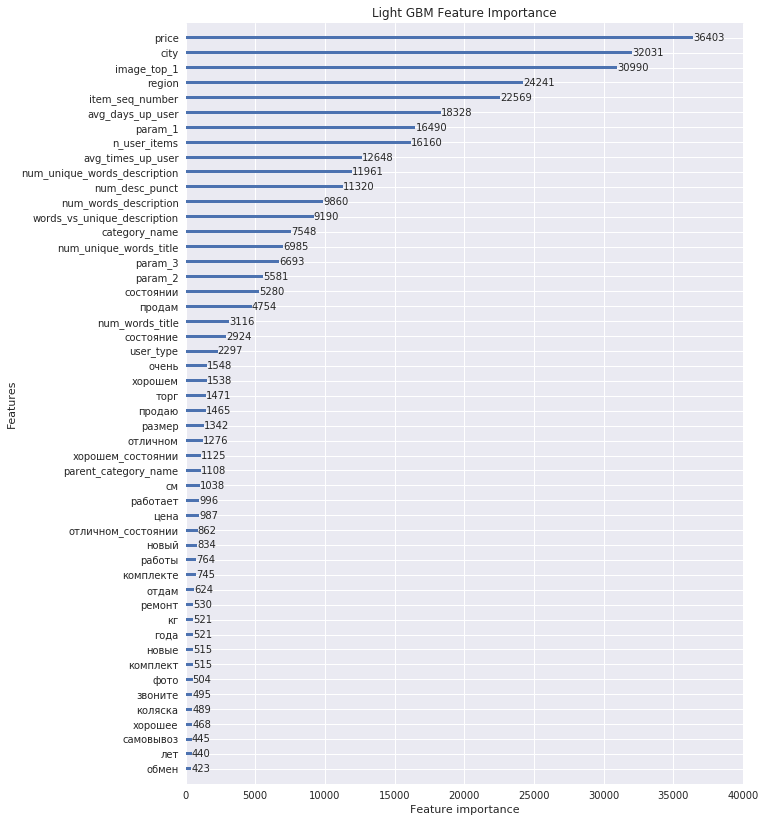

In [47]:
fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [48]:
subm = pd.read_csv('../sample_submission.csv')
subm['deal_probability'] = np.clip(model.predict(x_test), 0, 1)
subm.to_csv('aggregate.csv', index=False)

! kaggle competitions submit -c avito-demand-prediction -f aggregate.csv -m "Message"

Successfully submitted to Avito Demand Prediction Challenge

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!

In [43]:
from sklearn.feature_selection import SelectFromModel

X_temp = SelectFromModel(model, prefit=True, threshold=1).transform(x_train)
testing_temp = SelectFromModel(model, prefit=True, threshold=1).transform(x_test)
X_temp.shape, y.shape, testing_temp.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').